In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,42,FEMALE,0.95256,2.15000,0.007972,-0.048340,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,20-May-18,26-Aug-18,Alive
1,54,FEMALE,0.00000,1.38020,-0.498030,-0.507320,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,26-Apr-18,25-Jan-19,Dead
2,63,FEMALE,-0.52303,1.76400,-0.370190,0.010815,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Lumpectomy,24-Aug-18,08-Apr-20,Alive
3,78,FEMALE,-0.87618,0.12943,-0.370380,0.132190,I,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,16-Nov-18,28-Jul-20,Alive
4,42,FEMALE,0.22611,1.74910,-0.543970,-0.390210,II,Infiltrating Ductal Carcinoma,Positive,Positive,Positive,Lumpectomy,12-Dec-18,05-Jan-19,Alive


## Quick EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 334 non-null    int64  
 1   Gender              334 non-null    object 
 2   Protein1            334 non-null    float64
 3   Protein2            334 non-null    float64
 4   Protein3            334 non-null    float64
 5   Protein4            334 non-null    float64
 6   Tumour_Stage        334 non-null    object 
 7   Histology           334 non-null    object 
 8   ER status           334 non-null    object 
 9   PR status           334 non-null    object 
 10  HER2 status         334 non-null    object 
 11  Surgery_type        334 non-null    object 
 12  Date_of_Surgery     334 non-null    object 
 13  Date_of_Last_Visit  317 non-null    object 
 14  Patient_Status      321 non-null    object 
dtypes: float64(4), int64(1), object(10)
memory usage: 39.3+ K

In [4]:
df.describe(include='object').T

,count,unique,top,freq
Gender,334,2,FEMALE,330
Tumour_Stage,334,3,II,189
Histology,334,3,Infiltrating Ductal Carcinoma,233
ER status,334,1,Positive,334
PR status,334,1,Positive,334
HER2 status,334,2,Negative,305
Surgery_type,334,4,Other,105
Date_of_Surgery,334,181,06-Nov-18,5
Date_of_Last_Visit,317,285,09-Aug-19,3
Patient_Status,321,2,Alive,255


In [5]:
df.Gender.value_counts()  ## mostly in females

FEMALE    330
MALE        4
Name: Gender, dtype: int64

Text(0.5, 0, 'Patient Status')

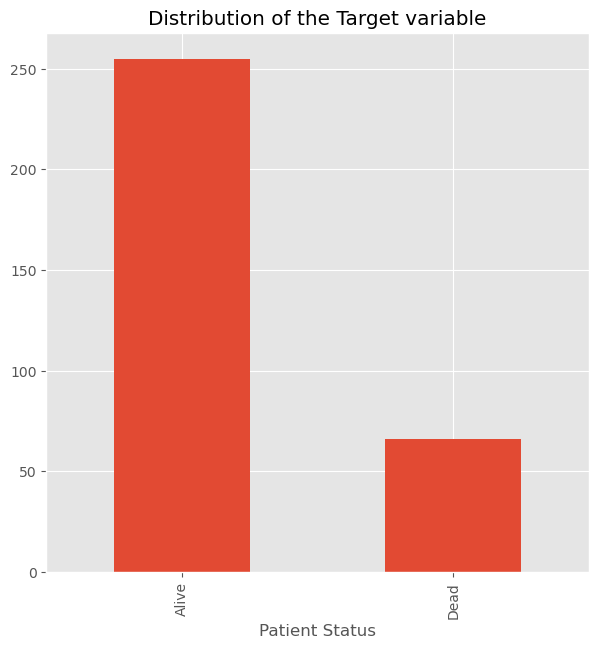

In [6]:
ax = df.Patient_Status.value_counts().sort_index().plot(kind='bar',figsize=(7,7),
                                                       title='Distribution of the Target variable')
ax.set_xlabel('Patient Status')

Since the target variable is unbalanced, there is a need to oversample or undersample the target variables so that the model can generalize better.

array([<AxesSubplot:ylabel=' '>], dtype=object)

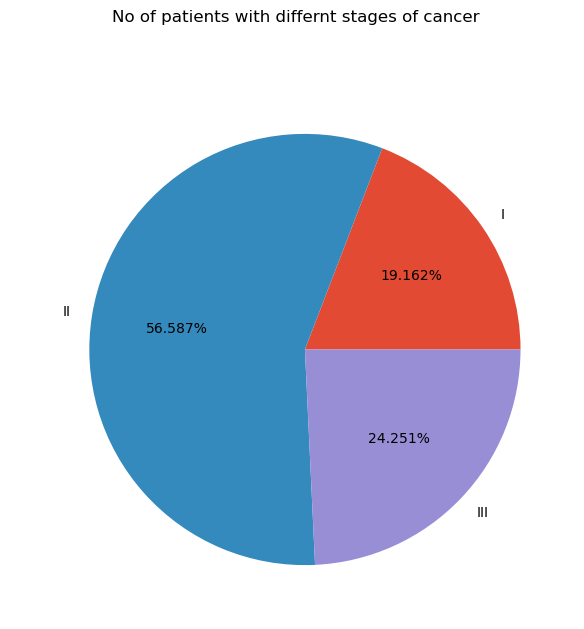

In [7]:
df.Tumour_Stage.value_counts().sort_index().plot(kind='pie',figsize=(7,7),subplots=True,
                                                title='No of patients with differnt stages of cancer',
                                                ylabel=" ",legend=False,autopct='%1.3f%%')

array([<AxesSubplot:title={'center':'Histology'}>], dtype=object)

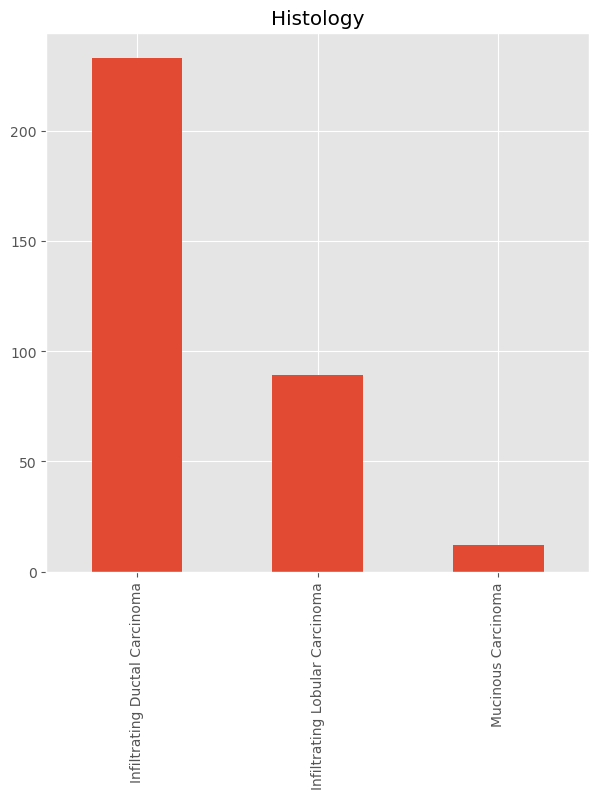

In [8]:
df.Histology.value_counts().plot(kind='bar',subplots=True,legend=False,figsize=(7,7))

## Preprocessing Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder

In [10]:
# Drop ER and PR status
df.drop(['ER status', 'PR status'], axis=1, inplace=True)

# Encode Tumour_Stage, Histology, and Surgery_type using OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['I', 'II', 'III', 'IV'], 
                                              ['Infiltrating Ductal Carcinoma', 'Infiltrating Lobular Carcinoma', 'Mucinous Carcinoma'],
                                              ['Other', 'Lumpectomy', 'Modified Radical Mastectomy','Simple Mastectomy']])
df[['Tumour_Stage', 'Histology', 'Surgery_type']] = ordinal_encoder.fit_transform(df[['Tumour_Stage', 'Histology', 'Surgery_type']])

# Encode Gender and HER2 status using binary encoding
df = pd.get_dummies(df, columns=['Gender', 'HER2 status'], drop_first=True)

# Extract year, month, and day from Date_of_Surgery and Date_of_Last_Visit
df['Surgery_Year'] = pd.DatetimeIndex(df['Date_of_Surgery']).year
df['Surgery_Month'] = pd.DatetimeIndex(df['Date_of_Surgery']).month
df['Surgery_Day'] = pd.DatetimeIndex(df['Date_of_Surgery']).day
df.drop('Date_of_Surgery', axis=1, inplace=True)

df['LastVisit_Year'] = pd.DatetimeIndex(df['Date_of_Last_Visit']).year
df['LastVisit_Month'] = pd.DatetimeIndex(df['Date_of_Last_Visit']).month
df['LastVisit_Day'] = pd.DatetimeIndex(df['Date_of_Last_Visit']).day
df.drop('Date_of_Last_Visit', axis=1, inplace=True)

In [11]:
numerical_columns = [column for column in df.columns if df[column].dtype in ['int64','float64']]

numerical_preprocessor = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='mean')),
    ("scaler",StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("onehot",OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
transformers=[
    ("numerical",numerical_preprocessor,numerical_columns)
])

In [12]:
X = df.drop("Patient_Status",axis=1)
y = df.Patient_Status

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,
                                                y,
                                                test_size=0.2,
                                                random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Evaluating accuracy across all models

In [13]:
!pip install lazypredict

In [14]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
model,predictions = clf.fit(X_train,X_test,y_train,y_test)
print(predictions)

100%|██████████| 29/29 [00:02<00:00, 10.44it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
DecisionTreeClassifier             0.73               0.69    None      0.73   
GaussianNB                         0.81               0.68    None      0.76   
AdaBoostClassifier                 0.52               0.67    None      0.57   
LGBMClassifier                     0.75               0.55    None      0.71   
ExtraTreesClassifier               0.81               0.47    None      0.74   
RandomForestClassifier             0.79               0.44    None      0.71   
XGBClassifier                      0.73               0.42    None      0.68   
ExtraTreeClassifier                0.70               0.39    None      0.71   
LinearDiscriminantAnalysis         0.79               0.36    None      0.71   
LogisticRegression                 0.79               0.36    None      0.71   
NearestCentroid                    0.34 

## Neural Network

In [15]:
import torch

X_train_tensor = torch.from_numpy(X_train)
X_test_tensor = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

In [57]:
import torch.nn as nn
import torch.optim as optim

class PyTorchModel(nn.Module):
    def __init__(self, input_shape, num_classes, units=[16, 16, 16, 16],dropout=0.1, learning_rate=8e-3):
        super(PyTorchModel,self).__init__()
        self.fc1 = nn.Linear(input_shape[1], units[0])
        self.fc2 = nn.Linear(units[0], units[1])
        self.fc3 = nn.Linear(units[1], units[2])
        self.fc4 = nn.Linear(units[2], units[3])
        self.fc5 = nn.Linear(units[3], num_classes)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = x.to(self.fc1.weight.dtype)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.softmax(self.fc5(x))
        return x

In [48]:
input_shape = (None, X_train_tensor.shape[1])
num_classes=3

# Define the model, optimizer and loss function
model = PyTorchModel(input_shape=input_shape,num_classes=num_classes)
optimizer = optim.Adam(model.parameters(),lr=8e-3)
criterion = nn.CrossEntropyLoss()

In [18]:
# Define the training loop
def train_loop(model,optimizer,criterion,X_train,y_train,X_val,y_val,epochs=10,batch_size=1):
    for epoch in range(epochs):
        # Shuffle the training data
        #indices = np.random.permutation(len(X_train))
        #X_train = X_train[indices]
        #y_train = y_train[indices]
        
        #Train the modelon batches of data
        for i in range(0,len(X_train),batch_size):
            # Extract a batch of data
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            #Forward pass
            output = model(batch_X)
            loss = criterion(output,batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # Evaluate the model on validation data
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output,y_val)
            val_accuracy = (val_output.argmax(dim=1) == y_val).float().mean()
            
        # Print the result for a epoch
        print(f"Epoch:{epoch+1}  "
             f"train_loss:{loss:.4f}  "
             f"val_loss:{val_loss:.4f}  "
             f"val_acc:{val_accuracy:.4f}")

In [19]:
# Train the model
train_loop(model,optimizer,criterion,X_train_tensor,y_train_tensor,
          X_test_tensor,y_test_tensor,epochs=20)

Epoch:1  train_loss:0.5515  val_loss:0.7753  val_acc:0.7761
Epoch:2  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:3  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:4  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:5  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:6  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:7  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:8  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:9  train_loss:0.5514  val_loss:0.7754  val_acc:0.7761
Epoch:10  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:11  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:12  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:13  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:14  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:15  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:16  train_loss:0.5514  val_loss:0.7753  val_acc:0.7761
Epoch:17  train_loss:0.5514  val_

The neural net can further be improved by adjusting no. of units, learning rate, increasing the no. of layers, etc. If you like this notebook, don't forget to **upvote** it.